In [1]:
from astropy.io import fits
from pathlib import Path
import os, sys

SRC_DIR = str(Path('.').resolve().parents[1])
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

import utils

### $\xi^{(i,j)}_\theta$ definition

In [47]:
from numba import njit

@njit
def _inv_H_LCDM(z, H0, omega_m):
    return 1.0 / _H_LCDM(z, H0, omega_m)

def integral_trapezoid(func, a, b, N, **kwargs):
    h = (b - a) / N
    result = 0.5 * (func(a, **kwargs) + func(b, **kwargs))
    for i in range(1, N):
        result += func(a + i * h, **kwargs)
    result *= h
    return result

@njit
def _H_LCDM(z, H0, Omega_m_0):
    return H0 * np.sqrt(Omega_m_0 * (1 + z)**3 + (1 - Omega_m_0))

def get_chi(z, H0, omega_m, c):
    return c * integral_trapezoid(_inv_H_LCDM, 0.0, z, 100, H0=H0, omega_m=omega_m)

@njit
def get_z(chi_val, chi_vals, z_vals):
    i_chi = np.argmin(np.abs(chi_vals-chi_val))
    return z_vals[i_chi]

@njit
def get_n(i_bin, z, n_bins_list):
    i_nearest = np.argmin(np.abs(z_vals - z))
    return n_bins_list[i_nearest, i_bin]

@njit
def integrand_w(chi_val_integrand, chi_val_W, chi_vals, z_vals, n_bins_list, i, H0, omega_m, c):
    z_chi_integrand = get_z(chi_val_integrand, chi_vals, z_vals)
    dz_dchi_integrand = _H_LCDM(z_chi_integrand, H0, omega_m) / c
    n_i_z = get_n(i_bin=i, z=z_chi_integrand, n_bins_list=n_bins_list)
    return n_i_z * dz_dchi_integrand * (chi_val_integrand - chi_val_W) / chi_val_integrand

def w(i, chi_val, z_chi_val, chi_vals, z_vals, n_bins_list, chi_H, H0, omega_m, c):
    integral = integral_trapezoid(integrand_w, chi_val, chi_H, 100, chi_val_W=chi_val, chi_vals=chi_vals, z_vals=z_vals, n_bins_list=n_bins_list, i=i, H0=H0, omega_m=omega_m, c=c)
    return 1.5 * omega_m * (H0/c)**2 * chi_val * (1+z_chi_val) * integral

### Intégrer P

def integrand_ClEE(chi_val, i, j, l, H0, omega_m, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals, n_bins_list):
    z_chi_val = get_z(chi_val=chi_val, chi_vals=chi_vals, z_vals=z_vals)
    P_cal = utils.cosmo.P(k=(l+0.5)/chi_val, z=z_chi_val, Omega_m_0=Omega_m, Omega_b_0=Omega_b, Omega_gamma=Omega_gamma, h=h, c=c, n_s=n_s, k_star=k_star, A_s=A_s, fact=fact)
    return w(i=i, chi_val=chi_val, z_chi_val=z_chi_val, chi_vals=chi_vals, z_vals=z_vals, n_bins_list=n_bins_list, chi_H=chi_H, H0=H0, omega_m=omega_m, c=c) * w(i=j, chi_val=chi_val, z_chi_val=z_chi_val, chi_vals=chi_vals, z_vals=z_vals, n_bins_list=n_bins_list, chi_H=chi_H, H0=H0, omega_m=omega_m, c=c) / (chi_val**2) * P_cal

def ClEE(i, j, l, H0, omega_m, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals, n_bins_list):
    return integral_trapezoid(integrand_ClEE, 1e-6, chi_H, 100, i=i, j=j, l=l, H0=H0, omega_m=omega_m, Omega_m=Omega_m, Omega_b=Omega_b, Omega_gamma=Omega_gamma, h=h, c=c, n_s=n_s, k_star=k_star, A_s=A_s, fact=fact, chi_H=chi_H, chi_vals=chi_vals, z_vals=z_vals, n_bins_list=n_bins_list)

def ClBB(i, j, l):
    return 0.0

def Gp(x, l, aL_pols):
    return - ( (l-4) / (1-x**2) + 0.5 * l * (l-1) ) * aL_pols[l](x) + (l+2) * (x / (1-x**2)) * aL_pols[l-1](x)

def Gm(x, l, aL_pols):
    return 2 * ( (l-1) * x / (1-x**2) * aL_pols[l](x) - (l+2) * (1 / (1-x**2)) * aL_pols[l-1](x))

def xip(theta, i, j, aL_pols, H0, omega_m, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals, n_bins_list, nb_l):
    xi = 0.0
    for l in range(2, nb_l):
        xi += (2*l + 1)/(2*np.pi * l**2 * (l+1)**2) * (Gp(x=np.cos(theta), l=l, aL_pols=aL_pols) + Gm(x=np.cos(theta), l=l, aL_pols=aL_pols)) * (ClEE(i, j, l, H0, omega_m, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals, n_bins_list) + ClBB(i, j, l))
        print(f"xip(l_max={l}) = {xi}")
    return xi

def xim(theta, i, j, aL_pols, H0, omega_m, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals, n_bins_list, nb_l):
    xi = 0.0
    for l in range(2, nb_l):
        xi += (2*l + 1)/(2*np.pi * l**2 * (l+1)**2) * (Gp(x=np.cos(theta), l=l, aL_pols=aL_pols) - Gm(x=np.cos(theta), l=l, aL_pols=aL_pols)) * (ClEE(i, j, l, H0, omega_m, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals, n_bins_list) - ClBB(i, j, l))
    return xi

def chi2_desy3(des_fulldata, nb_l, aL_pols, H0, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals):
    xip_fulldata, xim_fulldata = des_fulldata[0], des_fulldata[1]
    N_xip = len(xip_fulldata[0])
    N_xim = len(xim_fulldata[0])
    N = N_xip + N_xim
    omega_m = Omega_m * h**2

    delta_xi = np.empty(N)
    for i in range(1):
        if i < N_xip:
            delta_xi[i] = xip_fulldata[0][i] - xip(theta=xip_fulldata[1][i],
                                                    i=xip_fulldata[2][i],
                                                    j=xip_fulldata[3][i],
                                                    aL_pols=aL_pols,
                                                    H0=H0,
                                                    omega_m=omega_m,
                                                    Omega_m=Omega_m,
                                                    Omega_b=Omega_b,
                                                    Omega_gamma=Omega_gamma,
                                                    h=h,
                                                    c=c,
                                                    n_s=n_s,
                                                    k_star=k_star,
                                                    A_s=A_s,
                                                    fact=fact,
                                                    chi_H=chi_H,
                                                    chi_vals=chi_vals,
                                                    z_vals=z_vals,
                                                    n_bins_list=des_fulldata[2],
                                                    nb_l=nb_l)
        elif N_xip <= i < N_xim:
            delta_xi[i] = xim_fulldata[0][i] - xim(theta=xim_fulldata[1][i],
                                                i=xim_fulldata[2][i],
                                                j=xim_fulldata[3][i],
                                                aL_pols=aL_pols,
                                                H0=H0,
                                                omega_m=omega_m,
                                                Omega_m=Omega_m,
                                                Omega_b=Omega_b,
                                                Omega_gamma=Omega_gamma,
                                                h=h,
                                                c=c,
                                                n_s=n_s,
                                                k_star=k_star,
                                                A_s=A_s,
                                                fact=fact,
                                                chi_H=chi_H,
                                                chi_vals=chi_vals,
                                                z_vals=z_vals,
                                                n_bins_list=des_fulldata[2],
                                                nb_l=nb_l)

    print(f'diff={delta_xi[0]}, calculé={xip_fulldata[0][i]-delta_xi[0]}, théorique={xip_fulldata[0][i]}')
    return delta_xi @ des_fulldata[3] @ delta_xi

In [49]:
import numpy as np

file_path = 'DES-Y3_xipm_and_KiDS-1000_COSEBIs_2.0_300.0.fits'

with fits.open(file_path) as hdul:
    # hdul.info()
    xip_data = hdul['xip'].data
    xim_data = hdul['xim'].data
    covmat = hdul['COVMAT'].data
    nz_data_des = hdul['nz_source_des'].data
    nz_source_kids = hdul['nz_source_kids'].data

z_vals_des = nz_data_des['Z_MID']
covmat_desy3 = covmat[:400, :400]
covmat_kids = covmat[400:, 400:]

z_vals_kids = nz_source_kids['Z_MID']
n_bin1 = nz_data_des['BIN1']

xi_minus_data = xim_data['VALUE']
xi_minus_ang = xim_data['ANG']
xi_plus_data = xip_data['VALUE']
xi_plus_ang = xip_data['ANG']

nb_l = 50

H0 = 73.4
h = 0.674
c = 299792.458
Omega_m = 0.315
Omega_b = 0.049
Omega_gamma = 2.47e-5 / h**2
n_s = 2.1e-9
n_s = 0.965
k_star = 0.05

A_s = 2.1e-9

chi_H = 0.5 ## valeur fausse

N_eff = 3.046
R_nu = (0.2271 * N_eff) / (1 + 0.2271 * N_eff) # 0.2271 = 7/8*(4/11)**(4/3)
fact = 1 / (1 + (4/15) * R_nu)
fact *= 0.855 ## temporary to fit with CLASS

z_vals = np.linspace(0, 10, 1000)
chi_vals = get_chi(z=z_vals, H0=H0, omega_m=Omega_m * h**2, c=c)

des_xip_fulldata = [xip_data['VALUE'], # xip
                    xip_data['ANG'], # theta
                    xip_data['BIN1'], # i
                    xip_data['BIN2'], # j
                    ]

des_xim_fulldata = [xim_data['VALUE'], # xim
                    xim_data['ANG'], # theta
                    xim_data['BIN1'], # i
                    xim_data['BIN2'], # j
                    ]

des_fulldata = [des_xip_fulldata,
                des_xim_fulldata,
                np.column_stack((nz_data_des['BIN1'],  # n_i(z) for i = 1
                                nz_data_des['BIN2'],   # ...
                                nz_data_des['BIN3'],   # ...
                                nz_data_des['BIN4'])), # n_i(z) for i = 4
                covmat_desy3,
                ]


res = chi2_desy3(des_fulldata=des_fulldata,
        nb_l=nb_l,
        aL_pols = utils.polynoms.AssociatedLegendrePolynomsCalculator(nb_l).polynoms,
        H0=H0,
        Omega_m=Omega_m,
        Omega_b=Omega_b,
        Omega_gamma=Omega_gamma,
        h=h,
        c=c,
        n_s=n_s,
        k_star=k_star,
        A_s=A_s,
        fact=fact,
        chi_H=chi_H,
        chi_vals=chi_vals,
        z_vals=z_vals)

xip(l_max=2) = 2.85337847569257e-36
xip(l_max=3) = 2.0672881323192974e-36
xip(l_max=4) = 2.3796652164689665e-36
xip(l_max=5) = 2.227059528449657e-36
xip(l_max=6) = 2.3125938541867566e-36
xip(l_max=7) = 2.2594512842456035e-36
xip(l_max=8) = 2.295333412674839e-36
xip(l_max=9) = 2.269380857086689e-36
xip(l_max=10) = 2.2892187574344725e-36
xip(l_max=11) = 2.2734148289561228e-36
xip(l_max=12) = 2.2863521811777473e-36
xip(l_max=13) = 2.275616068299347e-36
xip(l_max=14) = 2.284535042880899e-36
xip(l_max=15) = 2.2772048424046658e-36
xip(l_max=16) = 2.2830932788215597e-36
xip(l_max=17) = 2.2785358709814683e-36
xip(l_max=18) = 2.28186385572317e-36
xip(l_max=19) = 2.279657337900069e-36
xip(l_max=20) = 2.280864210795196e-36
xip(l_max=21) = 2.2805193783923193e-36
xip(l_max=22) = 2.2801535379385447e-36
xip(l_max=23) = 2.281069599307718e-36
xip(l_max=24) = 2.279766563148363e-36
xip(l_max=25) = 2.2812975434069778e-36
xip(l_max=26) = 2.2796864637350884e-36
xip(l_max=27) = 2.2812472749321315e-36
xip(l_m

## Comparison plots

-1.0039920763292391 -0.941865954665012 -0.9645675520018693
0.9729290154971255


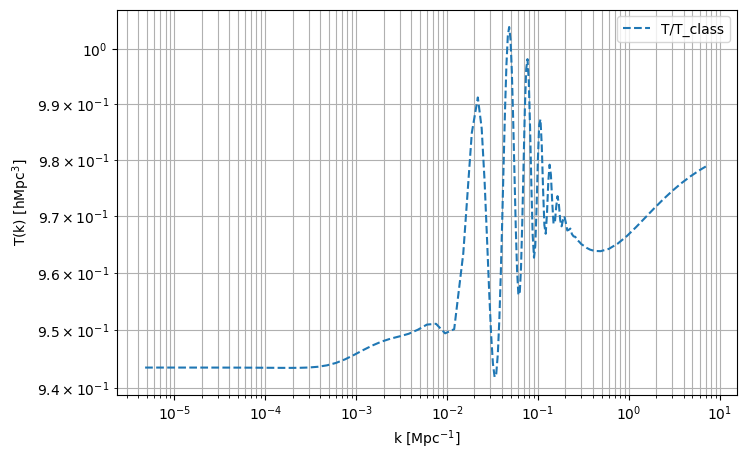

In [6]:
from classy import Class
import numpy as np
from matplotlib import pyplot as plt
from numba import njit

### PARAMETERS

c = 299792.458
h = 0.674
Omega_m = 0.315
Omega_b = 0.049
Omega_gamma = 2.47e-5 / h**2
A_s = 2.1e-9
n_s = 0.965
k_pivot = 0.05   # 1/Mpc
z = 5 # entre 0 et 6 pour KiDS (0 et 3 pour DESy3)
N_eff = 3.046
R_nu = (0.2271 * N_eff) / (1 + 0.2271 * N_eff) # 0.2271 = 7/8*(4/11)**(4/3)
fact = 1 / (1 + (4/15) * R_nu)
fact *= 0.855 ## temporary to fit with CLASS

### CLASS
cosmo = Class()
cosmo.set({
    'h': h,
    'omega_b': Omega_b * h**2,
    'omega_cdm': (Omega_m - Omega_b) * h**2,
    'A_s': A_s,
    'n_s': n_s,
    'output': 'dTk,mPk',
    'P_k_max_1/Mpc': 10.0,
    'z_max_pk': 5.0
})
cosmo.compute()

transfer, k_grid, z_grid = cosmo.get_transfer_and_k_and_z()

compare = {
    'T-T_class': True,
    'P(T_class)-P_class': False,
    'P-P_class': False
}

iz = np.argmin(np.abs(z_grid - z))

if compare['P(T_class)-P_class']:
    plt.figure(figsize=(8,5))
    P_cal = utils.cosmo._P_k_z(k=k_grid, A_s=A_s, k_star=k_pivot, n_s=n_s, Tdm=transfer['d_m'][:, iz])
    P_class = np.array([cosmo.pk_lin(k, z) for k in k_grid])
    ratio = P_cal / P_class
    print(ratio.min(), ratio.max(), ratio.mean())
    plt.loglog(h*k_grid, P_class, label='P_class')
    plt.loglog(h*k_grid, P_cal, label='P(T_class)')
    plt.loglog(h*k_grid, P_cal/P_class, '--', label='P(T_class)/P_class')
    plt.grid(True, which='both')
    plt.xlabel('k [Mpc$^{-1}$]')
    plt.ylabel('P(k) [hMpc$^3$]')
    plt.legend();
if compare['T-T_class']:
    plt.figure(figsize=(8,5))
    T = utils.cosmo._T_k_z(k=k_grid, z=z, Omega_m_0=Omega_m, Omega_b_0=Omega_b, Omega_gamma=Omega_gamma, h=h, c=c, fact=fact)
    T_class = transfer['d_m'][:, iz]
    ratio = T / T_class
    print(ratio.min(), ratio.max(), ratio.mean())
    print(0.5*(np.abs(ratio).min()+np.abs(ratio).max()))
    # plt.loglog(h*k_grid, -T_class, label='T_class')
    # plt.loglog(h*k_grid, T, label='T')
    plt.loglog(h*k_grid, -T/T_class, '--', label='T/T_class')
    plt.grid(True, which='both')
    plt.xlabel('k [Mpc$^{-1}$]')
    plt.ylabel('T(k) [hMpc$^3$]')
    plt.legend();
if compare['P-P_class']:
    plt.figure(figsize=(8,5))
    # T = utils.T_k_z(k=k_grid, z=z, Omega_m_0=Omega_m, Omega_b_0=Omega_b, Omega_gamma=Omega_gamma, h=h, c=c, fact=fact)
    # P = utils.P_k_z(k=k_grid, A_s=A_s, k_star=k_pivot, n_s=n_s, Tdm=T)
    P_cal = utils.cosmo.P(k_grid, z, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_pivot, A_s, fact)
    P_class = np.array([cosmo.pk_lin(k, z) for k in k_grid])
    ratio = P_cal / P_class
    print(ratio.min(), ratio.max(), ratio.mean())
    plt.loglog(h*k_grid, P_class, label='P_class')
    plt.loglog(h*k_grid, P_cal, label='P')
    plt.loglog(h*k_grid, P_cal/P_class, '--', label='P/P_class')
    plt.grid(True, which='both')
    plt.xlabel('k [hMpc$^{-1}$]')
    plt.ylabel('P(k) [Mpc$^3$]')
    plt.legend();

/tmp/ipykernel_14754/942024579.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("YlOrRd")


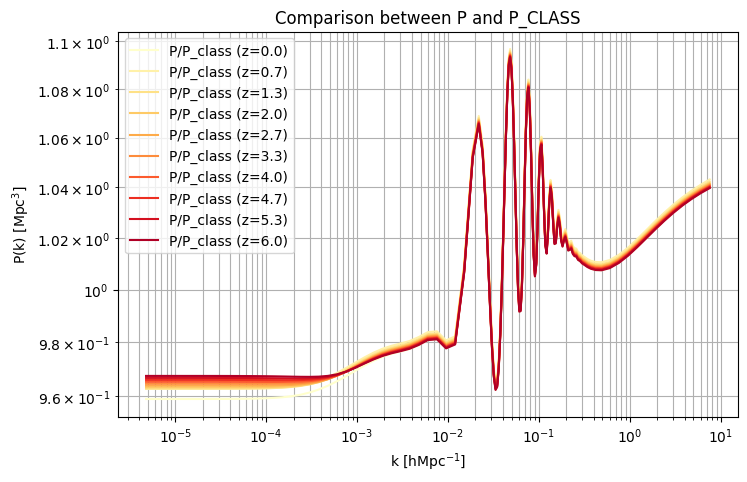

In [9]:
from matplotlib import cm  # colormaps
from matplotlib.colors import Normalize

cosmo = Class()
cosmo.set({
    'h': h,
    'omega_b': Omega_b * h**2,
    'omega_cdm': (Omega_m - Omega_b) * h**2,
    'A_s': A_s,
    'n_s': n_s,
    'output': 'mPk',

    'P_k_max_1/Mpc': 10.0,
    'z_max_pk': 5.0,
})
cosmo.compute()

k_vals = np.logspace(-3, 1, 124)

# Tracer
plt.figure(figsize=(8,5))
Nz = 10
z_array = np.linspace(0,6,Nz)

norm = Normalize(vmin=0, vmax=Nz)
cmap = cm.get_cmap("YlOrRd")
for i in range(len(z_array)):
    z = z_array[i]
    T = utils.cosmo._T_k_z(k=k_grid, z=z, Omega_m_0=Omega_m, Omega_b_0=Omega_b, Omega_gamma=Omega_gamma, h=h, c=c, fact=fact)
    P = utils.cosmo._P_k_z(k=k_grid, A_s=A_s, k_star=k_pivot, n_s=n_s, Tdm=T)
    P_class = np.array([cosmo.pk_lin(k, z) for k in k_grid])
    ratio = P / P_class
    plt.loglog(h*k_grid, P/P_class, color=cmap(norm(i)), label=f'P/P_class (z={z:.1f})')

plt.legend(); plt.xlabel('k [hMpc$^{-1}$]'); plt.ylabel('P(k) [Mpc$^3$]')
plt.title(f'Comparison between P and P_CLASS')
plt.grid(True, which='both')
plt.show()
